In [ ]:
import os
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths (already split previously)
train_dir = "/content/drive/MyDrive/ECGN_Split_3way/train"
val_dir = "/content/drive/MyDrive/ECGN_Split_3way/val"
test_dir = "/content/drive/MyDrive/ECGN_Split_3way/test"

Device: cuda


# -----------------------------------------
# STEP 2: Data Transforms & Loaders
# -----------------------------------------

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_data   = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_data  = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['AHB', 'MI', 'Normal']


# -----------------------------------------
# STEP 3: Load ResNet50 & Unfreeze Layer3 + Layer4 + fc
# -----------------------------------------

In [ ]:
model = models.resnet50(pretrained=True)

for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# -----------------------------------------
# STEP 4: Loss, Optimizer, Scheduler
# -----------------------------------------

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


# -----------------------------------------
# STEP 5: Training Loop with Early Stopping
# -----------------------------------------

In [ ]:
import copy
import torch
from tqdm import tqdm  # progress bar

# Training configuration
num_epochs = 50
patience = 10
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

best_val_acc = 0.0
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # Prevent memory leak

    model.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\n🔁 Epoch {epoch+1}/{num_epochs} (Training)")
    for images, labels in tqdm(train_loader, desc="Training Batch"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_acc)

    print(f" Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/resnet50_finetuned_best.pth")
        print(" Best model saved.")
    else:
        counter += 1
        print(f"⏳ No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print(" Early stopping triggered.")
            break

# Load best weights after early stop
model.load_state_dict(best_model_wts)
print("\n Training complete. Best Val Accuracy: {:.2f}%".format(best_val_acc))



🔁 Epoch 1/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


 Epoch [1/50] | Train Loss: 0.3853, Train Acc: 96.90% | Val Loss: 0.3640, Val Acc: 96.67%
 Best model saved.

🔁 Epoch 2/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


 Epoch [2/50] | Train Loss: 0.3445, Train Acc: 98.57% | Val Loss: 0.3937, Val Acc: 94.44%
⏳ No improvement. Patience: 1/10

🔁 Epoch 3/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


 Epoch [3/50] | Train Loss: 0.3764, Train Acc: 97.62% | Val Loss: 0.3748, Val Acc: 96.67%
⏳ No improvement. Patience: 2/10

🔁 Epoch 4/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


 Epoch [4/50] | Train Loss: 0.3473, Train Acc: 98.81% | Val Loss: 0.3814, Val Acc: 95.56%
⏳ No improvement. Patience: 3/10

🔁 Epoch 5/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


 Epoch [5/50] | Train Loss: 0.3299, Train Acc: 100.00% | Val Loss: 0.3646, Val Acc: 97.78%
 Best model saved.

🔁 Epoch 6/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


 Epoch [6/50] | Train Loss: 0.3918, Train Acc: 97.14% | Val Loss: 0.4096, Val Acc: 93.33%
⏳ No improvement. Patience: 1/10

🔁 Epoch 7/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


 Epoch [7/50] | Train Loss: 0.3967, Train Acc: 97.62% | Val Loss: 0.3757, Val Acc: 96.67%
⏳ No improvement. Patience: 2/10

🔁 Epoch 8/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


 Epoch [8/50] | Train Loss: 0.3625, Train Acc: 97.86% | Val Loss: 0.3581, Val Acc: 96.67%
⏳ No improvement. Patience: 3/10

🔁 Epoch 9/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


 Epoch [9/50] | Train Loss: 0.4558, Train Acc: 97.86% | Val Loss: 0.3801, Val Acc: 95.56%
⏳ No improvement. Patience: 4/10

🔁 Epoch 10/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


 Epoch [10/50] | Train Loss: 0.3552, Train Acc: 97.62% | Val Loss: 0.3582, Val Acc: 97.78%
⏳ No improvement. Patience: 5/10

🔁 Epoch 11/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


 Epoch [11/50] | Train Loss: 0.3456, Train Acc: 99.05% | Val Loss: 0.3558, Val Acc: 96.67%
⏳ No improvement. Patience: 6/10

🔁 Epoch 12/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


 Epoch [12/50] | Train Loss: 0.3533, Train Acc: 98.57% | Val Loss: 0.3584, Val Acc: 96.67%
⏳ No improvement. Patience: 7/10

🔁 Epoch 13/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


 Epoch [13/50] | Train Loss: 0.3423, Train Acc: 97.62% | Val Loss: 0.3574, Val Acc: 96.67%
⏳ No improvement. Patience: 8/10

🔁 Epoch 14/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


 Epoch [14/50] | Train Loss: 0.3532, Train Acc: 97.62% | Val Loss: 0.3617, Val Acc: 96.67%
⏳ No improvement. Patience: 9/10

🔁 Epoch 15/50 (Training)


Training Batch: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


 Epoch [15/50] | Train Loss: 0.3610, Train Acc: 98.81% | Val Loss: 0.3582, Val Acc: 97.78%
⏳ No improvement. Patience: 10/10
 Early stopping triggered.

 Training complete. Best Val Accuracy: 97.78%


 Classification Report:

              precision    recall  f1-score   support

         AHB       0.93      0.93      0.93        30
          MI       0.94      1.00      0.97        30
      Normal       0.96      0.90      0.93        30

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90



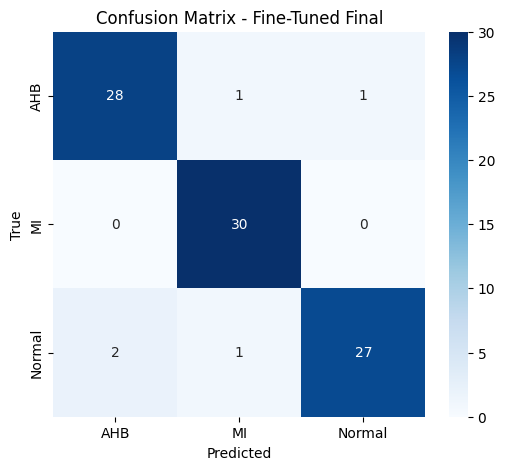

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Predict on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names (already defined earlier)
# class_names = ['AHB', 'MI', 'Normal']

# Print classification report
print(" Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuned Final")
plt.show()


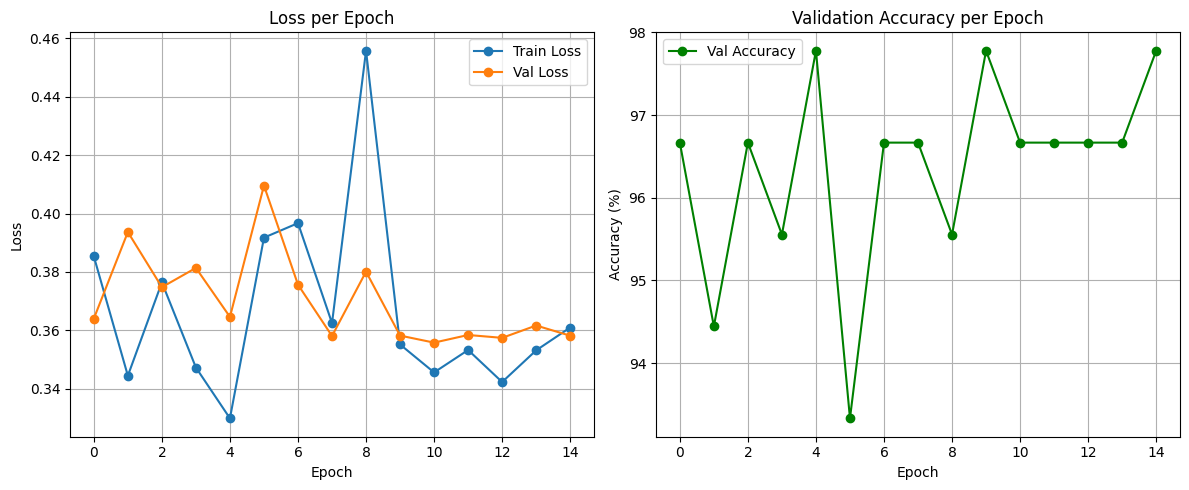

In [ ]:
# Training & validation curves
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss", marker='o')
plt.plot(val_loss_history, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label="Val Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_module = dict([*self.model.named_modules()])[self.target_layer]
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1)

        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
        return cam


In [ ]:
def show_resnet50_cam_examples(model, dataloader, class_names, target_layer='layer4', num_per_class=2):
    cam = GradCAM(model, target_layer=target_layer)
    model.eval()
    shown = {cls: 0 for cls in class_names}

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        probs = F.softmax(outputs, dim=1).detach().cpu().numpy()

        for i in range(images.size(0)):
            true_idx = labels[i].item()
            pred_idx = preds[i].item()
            class_name = class_names[true_idx]

            if shown[class_name] < num_per_class:
                cam_map = cam.generate_cam(images[i].unsqueeze(0))

                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize for display

                fig, ax = plt.subplots(1, 2, figsize=(10, 4))
                ax[0].imshow(img_np)
                ax[0].imshow(cam_map, cmap='jet', alpha=0.5)
                ax[0].set_title(f"True: {class_names[true_idx]} | Pred: {class_names[pred_idx]}")
                ax[0].axis('off')

                ax[1].barh(class_names, probs[i], color='skyblue')
                ax[1].set_xlim(0, 1)
                ax[1].set_title("Prediction Probabilities")
                for j, v in enumerate(probs[i]):
                    ax[1].text(v + 0.01, j, f"{v:.2f}", va='center')
                plt.tight_layout()
                plt.show()

                shown[class_name] += 1

            if all(v >= num_per_class for v in shown.values()):
                return


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


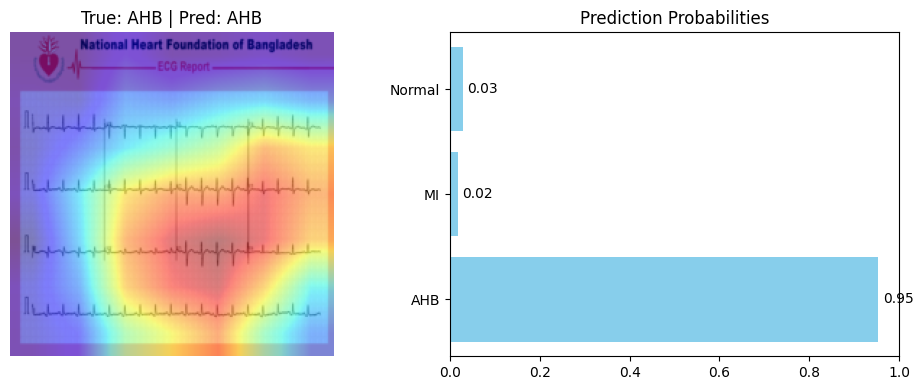

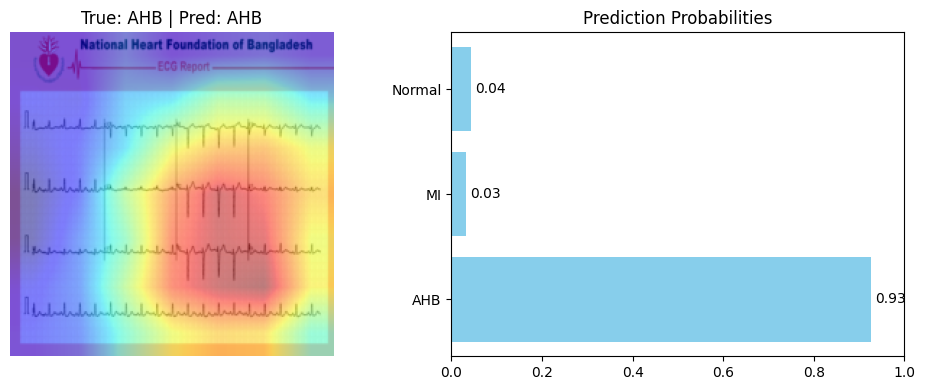

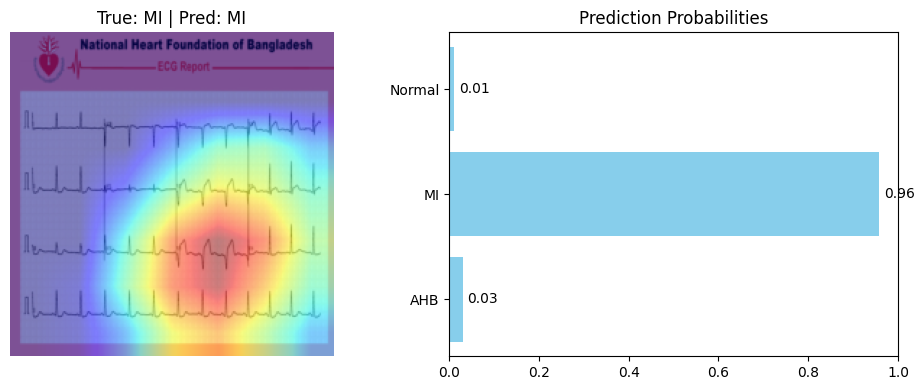

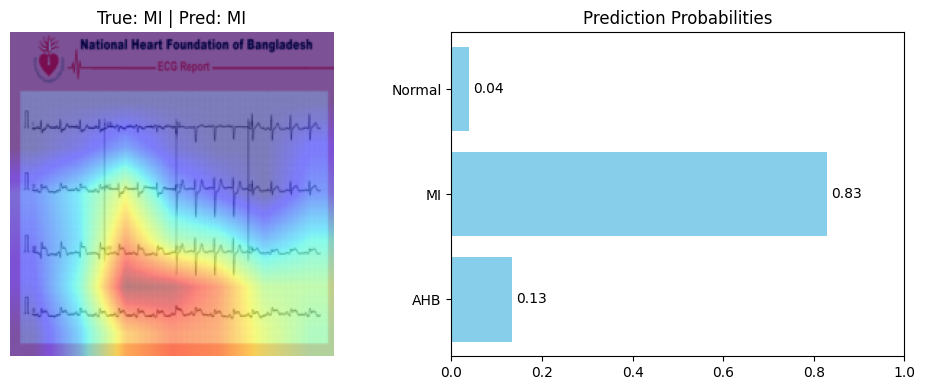

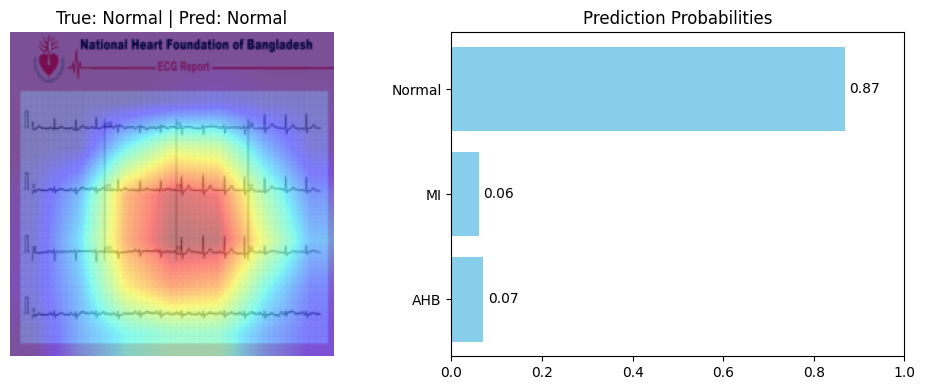

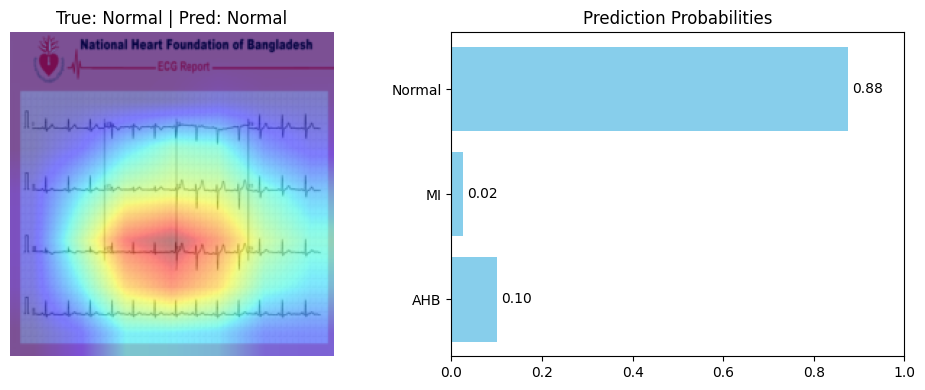

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_finetuned_best.pth"))
model.to(device)

show_resnet50_cam_examples(model, test_loader, class_names, target_layer='layer4', num_per_class=2)


**Full Code: Raw Pretrained ResNet50 for ECG Classification**

In [ ]:
import os, random, shutil
from pathlib import Path

src_dir = "/content/drive/MyDrive/ECGN"
dst_root = "/content/drive/MyDrive/ECGN_Split_Raw_NoSave"
train_dir = os.path.join(dst_root, "train")
val_dir = os.path.join(dst_root, "val")
test_dir = os.path.join(dst_root, "test")

def create_split(src, train_dst, val_dst, test_dst, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(src)
    for cls in classes:
        img_dir = os.path.join(src, cls)
        images = list(Path(img_dir).glob("*.jpg"))
        random.shuffle(images)
        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for dst in [train_dst, val_dst, test_dst]:
            os.makedirs(os.path.join(dst, cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(str(img), os.path.join(train_dst, cls, img.name))
        for img in val_imgs:
            shutil.copy(str(img), os.path.join(val_dst, cls, img.name))
        for img in test_imgs:
            shutil.copy(str(img), os.path.join(test_dst, cls, img.name))

if not os.path.exists(train_dir):
    create_split(src_dir, train_dir, val_dir, test_dir)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data   = datasets.ImageFolder(root=val_dir, transform=transform)
test_data  = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
train_loss_history, val_loss_history, val_acc_history = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/10] | Train Loss: 0.9796, Train Acc: 48.57% | Val Loss: 1.1125, Val Acc: 33.33%
Epoch [2/10] | Train Loss: 0.7492, Train Acc: 70.48% | Val Loss: 0.9584, Val Acc: 48.89%
Epoch [3/10] | Train Loss: 0.6350, Train Acc: 77.86% | Val Loss: 0.7228, Val Acc: 77.78%
Epoch [4/10] | Train Loss: 0.5849, Train Acc: 78.81% | Val Loss: 0.7488, Val Acc: 61.11%
Epoch [5/10] | Train Loss: 0.5580, Train Acc: 79.76% | Val Loss: 0.4966, Val Acc: 80.00%
Epoch [6/10] | Train Loss: 0.5635, Train Acc: 77.86% | Val Loss: 0.4499, Val Acc: 92.22%
Epoch [7/10] | Train Loss: 0.4923, Train Acc: 87.14% | Val Loss: 0.3976, Val Acc: 91.11%
Epoch [8/10] | Train Loss: 0.4188, Train Acc: 87.38% | Val Loss: 0.4101, Val Acc: 81.11%
Epoch [9/10] | Train Loss: 0.3743, Train Acc: 87.38% | Val Loss: 0.4228, Val Acc: 82.22%
Epoch [10/10] | Train Loss: 0.3608, Train Acc: 93.10% | Val Loss: 0.3764, Val Acc: 91.11%


Classification Report:

              precision    recall  f1-score   support

         AHB       0.91      0.70      0.79        30
          MI       0.86      1.00      0.92        30
      Normal       0.88      0.93      0.90        30

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.87        90
weighted avg       0.88      0.88      0.87        90



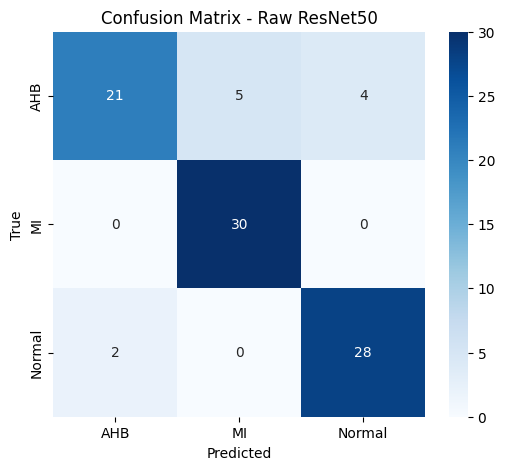

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Raw ResNet50")
plt.show()
